here we will randomize the deepwalk generated embeddings along the individual feature columns to determine if the distribution of the embeddings makes a difference in getting 0.5 roc results

2018-08-03

In [1]:
import pandas as pd
import numpy as np

from scipy import interp
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc
from sklearn.metrics import precision_recall_curve

from sklearn.linear_model import LogisticRegression

import seaborn as sns

from collections import defaultdict
from tqdm import tqdm

In [2]:
%matplotlib inline

---

In [3]:
def scramble_features(df, n):
    # scramble n columns of the features dataframe
    
    cols = list(df.columns)
    
    assert cols[0] == "uid"
    cols = cols[1:]
    
    assert n <= len(cols)
    
    # column names to scramble
    to_change = np.random.choice(cols, n, replace=False)
    
    assert len(set(to_change)) == n
    
    to_change = set(to_change)
    
    res = [
        df[["uid"]]
    ]
    
    for colname in cols:
        if colname in to_change:
            tmp = list(df[colname])
            
            np.random.shuffle(tmp)
            
            res.append(pd.Series(tmp).to_frame(colname))
        else:
            res.append(df[[colname]])
            
    return pd.concat(res, axis=1)

In [4]:
def pct_diff(orig, scrambled):
    assert orig.shape == scrambled.shape
    
    diff = (orig != scrambled)
    
    assert not diff["uid"].any()
    
    diff = diff.drop("uid", axis=1)
    
    shape = diff.shape
    
    return (diff.sum().sum()) / (shape[0] * shape[1]) * 100

In [5]:
def add_features(df, features, mergetype):
    return (df
        .merge(
            features, how=mergetype, left_on="chemical_uid", right_on="uid"
        )
        .drop("uid", axis=1)
        .merge(
            features, how=mergetype, left_on="disease_uid", right_on="uid"
        )
        .drop("uid", axis=1)
    )

def convolv_features(df, features, vecsize, mergetype):
    reg = add_features(df, features, mergetype)
    
    # do multiply and get rid of old features
    for i in range(vecsize):
        reg["conv{}".format(i)] = reg["f{}_x".format(i)] * reg["f{}_y".format(i)]

    reg = (reg
        .drop(
            ["f{}_x".format(i) for i in range(vecsize)], axis=1
        )
        .drop(
            ["f{}_y".format(i) for i in range(vecsize)], axis=1
        )
    )
        
    return reg

In [6]:
def eval_performance(idx, vecsize, num_scramble, debug=False):
    
    train = pd.read_csv(
        "data/min_hetionet/test/train_{}.tsv".format(idx), sep='\t'
    )
    
    holdout = pd.read_csv(
        "data/min_hetionet/test/holdout_{}.tsv".format(idx), sep='\t'
    )
    
    nodes = pd.read_csv("data/hetionet/deepwalk_ids.tsv", sep='\t')
    
    train = (train
        .merge(
            nodes[["deepwalk_id", "node_id"]],
            how="left", left_on="chemical_id", right_on="node_id"
        )
        .drop("node_id", axis=1)
        .rename(columns={"deepwalk_id": "chemical_uid"})

        .merge(
            nodes[["deepwalk_id", "node_id"]],
            how="left", left_on="disease_id", right_on="node_id"
        )
        .drop("node_id", axis=1)
        .rename(columns={"deepwalk_id": "disease_uid"})
    )
    
    holdout = (holdout
        .merge(
            nodes[["deepwalk_id", "node_id"]],
            how="left", left_on="chemical_id", right_on="node_id"
        )
        .drop("node_id", axis=1)
        .rename(columns={"deepwalk_id": "chemical_uid"})

        .merge(
            nodes[["deepwalk_id", "node_id"]],
            how="left", left_on="disease_id", right_on="node_id"
        )
        .drop("node_id", axis=1)
        .rename(columns={"deepwalk_id": "disease_uid"})
    )
    
    
    
    tmp = pd.read_csv(
        "data/min_hetionet/minhet_emb_{}.txt".format(vecsize),
        
        sep=" ", skiprows=1,
        names=["uid"] + ["f{}".format(i) for i in range(vecsize)]
    )
    
    features = scramble_features(tmp, num_scramble)
    
    if debug:
        print("Percent difference: {}%".format(pct_diff(tmp, features)))
    
    
    # train the model
    
    tmp = convolv_features(train, features, vecsize, "inner")

    feat_cols = ["conv{}".format(j) for j in range(vecsize)]
    regmodel = LogisticRegression(C=1e9).fit(tmp[feat_cols], tmp["etype"])

    # test on holdout
    test = convolv_features(
        holdout.drop("etype", axis=1),
        features, vecsize, "left"
    )

    assert len(test) == len(holdout)

    # if there are empty ones in the features column,
    # then we didn't generate any embeddings, and therefore
    # need to split those up and treat as zeroes
    # for the others we can predict normally, then join together

    regular = test[test["conv0"].notnull()].assign(missed = False)

    missed = (test[test["conv0"].isnull()]
        .assign(
            predval = 0
        )
        .assign(missed = True)
    )
    
    if debug:
        print("predicted {} missed {}".format(len(regular), len(missed)))

    # add in predictions
    ans = regular.assign(
        predval = lambda df: regmodel.predict_proba(df[feat_cols])[:, 1]
    )

    ans = ans.append(missed)

    assert len(ans) == len(holdout)

    return (ans
        [["chemical_uid", "disease_uid", "predval", "missed"]]
        .merge(
            holdout[["chemical_uid", "disease_uid", "etype"]],
            how="inner", on=["chemical_uid", "disease_uid"]
        )
        .sort_values("predval", ascending=False)
        .reset_index(drop=True)
    )

---

In [7]:
def roc_results(K, vecsize, num_scramble):
    tprs = []
    aucs = []
    mean_fpr = np.linspace(0, 1, 100)

    plt.figure(figsize=(8, 8))

    for idx in range(K):
        res = eval_performance(idx, vecsize, num_scramble, debug=True)

        fpr, tpr, thresh = roc_curve(res["etype"], res["predval"])

        tprs.append(interp(mean_fpr, fpr, tpr))
        tprs[-1][0] = 0
        auc_val = auc(fpr, tpr)
        aucs.append(auc_val)

        plt.plot(fpr, tpr, lw=1, alpha=0.3)

    # ---------------    

    plt.plot([0, 1], [0, 1], linestyle='--', lw=2, color='r', label='Luck', alpha=0.8)

    mean_tpr = np.mean(tprs, axis=0)
    mean_tpr[-1] = 1
    mean_auc = auc(mean_fpr, mean_tpr)
    std_auc = np.std(aucs)

    plt.plot(
        mean_fpr, mean_tpr, color='b',
        label="Mean ROC (AUC = %0.2f $\pm$ %0.2f)" % (mean_auc, std_auc),
        lw=2, alpha=0.8
    )

    std_tpr = np.std(tprs, axis=0)
    tprs_upper = np.minimum(mean_tpr + std_tpr, 1)
    tprs_lower = np.maximum(mean_tpr - std_tpr, 0)
    plt.fill_between(
        mean_fpr, tprs_lower, tprs_upper, color='grey',
        alpha=0.2, label="$\pm$ one sigma"
    )

    plt.xlim([-0.05, 1.05])
    plt.ylim([-0.05, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title("ROCs")

    plt.legend(loc="lower right")
    plt.show()

Percent difference: 0.0%
predicted 6673 missed 117
Percent difference: 0.0%
predicted 6014 missed 106
Percent difference: 0.0%
predicted 5288 missed 110
Percent difference: 0.0%
predicted 5593 missed 103
Percent difference: 0.0%
predicted 5856 missed 113


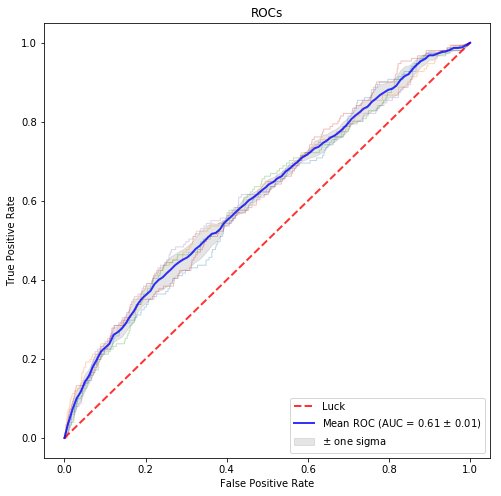

In [8]:
roc_results(5, 16, 0)

Percent difference: 99.98344266431185%
predicted 6673 missed 117
Percent difference: 99.98580799798158%
predicted 6014 missed 106
Percent difference: 99.98580799798158%
predicted 5288 missed 110
Percent difference: 99.98817333165132%
predicted 5593 missed 103
Percent difference: 99.98580799798158%
predicted 5856 missed 113


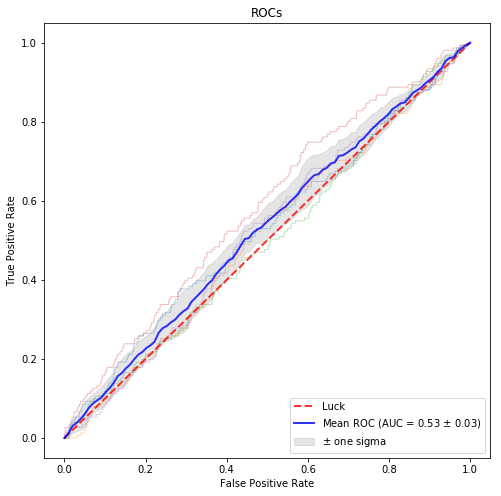

In [9]:
roc_results(5, 16, 16)

---

In [10]:
def no_graph_results(K, vecsize, num_scramble):
    aucs = []
    for idx in range(K):
        res = eval_performance(idx, vecsize, num_scramble)

        fpr, tpr, thresh = roc_curve(res["etype"], res["predval"])

        auc_val = auc(fpr, tpr)
        aucs.append(auc_val)

    return aucs

In [11]:
def scramble_graph(K, vecsize):
    res = defaultdict(list)
    
    stepsize = 1 if vecsize < 40 else 5
    
    for i in tqdm(range(0, vecsize+1, stepsize)):
        aucs = no_graph_results(K, vecsize, i)
        
        for auc in aucs:
            res["cols_scrambled"].append(i)
            res["auc_val"].append(auc)
            
    return pd.DataFrame(res).assign(vecsize = vecsize)

In [12]:
K = 5
temp = [
    scramble_graph(K, 2**i)
    for i in range(3, 8)
]

res = pd.concat(temp)

100%|██████████| 26/26 [01:59<00:00,  4.58s/it]


In [13]:
res.shape

(490, 3)

In [14]:
res.head()

,auc_val,cols_scrambled,vecsize
0,0.593761,0,8
1,0.617236,0,8
2,0.581459,0,8
3,0.610011,0,8
4,0.601695,0,8


In [15]:
fin = (res
    .assign(cols_changed_pct = lambda df: df["cols_scrambled"] / df["vecsize"])
)

In [16]:
fin.head()

,auc_val,cols_scrambled,vecsize,cols_changed_pct
0,0.593761,0,8,0.0
1,0.617236,0,8,0.0
2,0.581459,0,8,0.0
3,0.610011,0,8,0.0
4,0.601695,0,8,0.0


Text(0,0.5,'AUC of ROC curve')

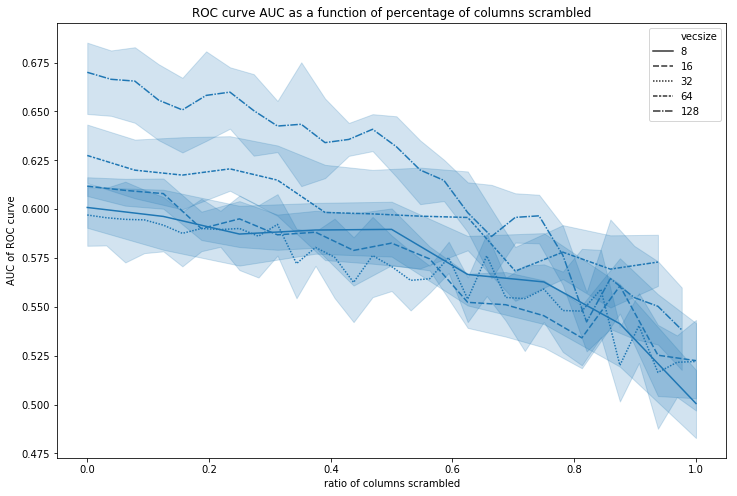

In [17]:
plt.figure(figsize=(12, 8))
    
fig = sns.lineplot(data=fin, x="cols_changed_pct", y="auc_val", style="vecsize")

fig.set_title("ROC curve AUC as a function of percentage of columns scrambled")
fig.set_xlabel("ratio of columns scrambled")
fig.set_ylabel("AUC of ROC curve")

Text(0,0.5,'AUC of ROC curve')

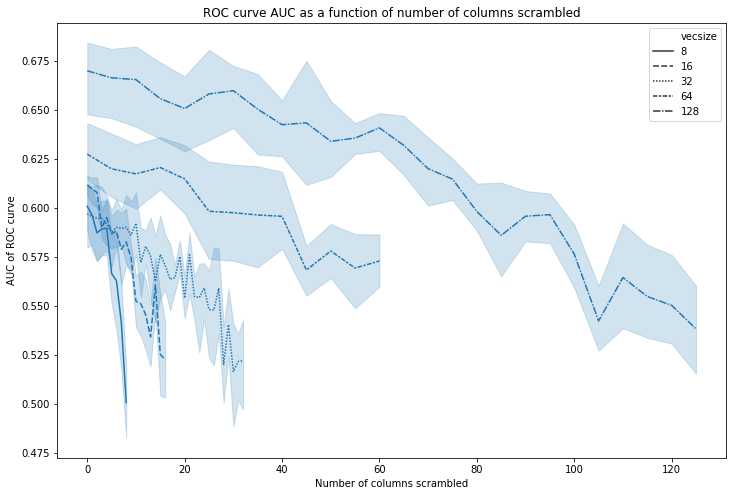

In [18]:
plt.figure(figsize=(12, 8))

fig = sns.lineplot(data=fin, x="cols_scrambled", y="auc_val", style="vecsize")

fig.set_title("ROC curve AUC as a function of number of columns scrambled")
fig.set_xlabel("Number of columns scrambled")
fig.set_ylabel("AUC of ROC curve")

---

Percent difference: 99.98639933139901%
predicted 6673 missed 117
Percent difference: 99.9871877759556%
predicted 6014 missed 106
Percent difference: 99.983639775451%
predicted 5288 missed 110
Percent difference: 99.98738488709475%
predicted 5593 missed 103
Percent difference: 99.98915888734705%
predicted 5856 missed 113


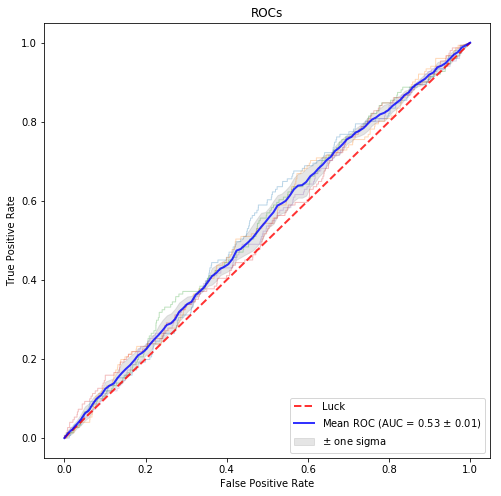

In [19]:
roc_results(5, 64, 64)

---

swapping the feature columns also seems to bring the roc down to 0.5. this is what we expect, and means that the new version of the code is working properly. this also shows that the amount of signal which is picked up by deepwalk increases as the feature space gets larger.

In terms of deepwalk the network degredation experiments might be a dead end because even when there are no shared nodes at all between the chemicals and diseases, the performance of the roc curve is too high. Edge degredation will probably not be successful, and we should try another approach.